Chan Vese assumes that the object to be identified have intensity different from the background. This assumption is not met with the nerve image. To fix this we should avoid using automatic estimation of $m_{in}$ and $m_{out}$, but rather fix those values based on the image. 

In [1]:
!pip install scikit-image numpy matplotlib opencv-python scipy
 

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D



In [3]:
path = 'data/nerves_part.tiff'
im = io.imread(path, plugin='pil').T
h,r,c = im.shape
h, r, c

(350, 350, 1024)

(-0.5, 349.5, 349.5, -0.5)

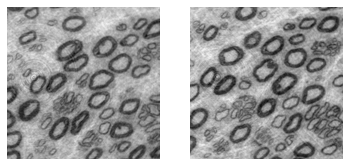

In [4]:
# visualise
fig, ax = plt.subplots(1,2)
plt.gray()
ax[0].imshow(im[:,:,0])
ax[1].imshow(im[:,:,-1])
ax[0].axis('off')
ax[1].axis('off')

mask

# 

In [83]:
import numpy as np
import scipy.interpolate
import scipy.linalg
import skimage.draw


def make_circular_snake(N, center, radius):
    """ Initialize circular snake as a 2-by-N array."""
    center = center.reshape([2,1])
    angles = np.arange(N)*2*np.pi/N
    return(center+radius*np.array([np.cos(angles), np.sin(angles)]))


def normalize(n):
    return n/np.sqrt(np.sum(n**2,axis=0))


def snake_normals(snake):
    """ Returns snake normals. Expects snake to be 2-by-N array."""
    ds = normalize(np.roll(snake, 1, axis=1) - snake) 
    tangent = normalize(np.roll(ds,-1,axis=1) + ds)
    normal = tangent[[1,0],:]*np.array([-1,1]).reshape([2,1])
    return(normal)


def distribute_points(snake):
    """ Distributes snake points equidistantly. Expects snake to be 2-by-N array."""
    N = snake.shape[1]
    d = np.sqrt(np.sum((np.roll(snake, -1, axis=1)-snake)**2, axis=0)) # length of line segments
    f = scipy.interpolate.interp1d(np.r_[0, np.cumsum(d)], np.c_[snake, snake[:,0:1]])
    return(f(sum(d)*np.arange(N)/N))


def is_crossing(p1, p2, p3, p4):
    """ Check if the line segments (p1, p2) and (p3, p4) cross."""
    crossing = False
    d21 = p2 - p1
    d43 = p4 - p3
    d31 = p3 - p1
    det = d21[0]*d43[1] - d21[1]*d43[0] # Determinant
    if det != 0.0 and d21[0] != 0.0 and d21[1] != 0.0:
        a = d43[0]/d21[0] - d43[1]/d21[1]
        b = d31[1]/d21[1] - d31[0]/d21[0]
        if a != 0.0:
            u = b/a
            if d21[0] > 0:
                t = (d43[0]*u + d31[0])/d21[0]
            else:
                t = (d43[1]*u + d31[1])/d21[1]
            crossing = 0 < u < 1 and 0 < t < 1         
    return crossing


def is_counterclockwise(snake):
    """ Check if points are ordered counterclockwise."""
    return np.dot(snake[0,1:] - snake[0,:-1],
                  snake[1,1:] + snake[1,:-1]) < 0


def remove_intersections(snake):
    """ Reorder snake points to remove self-intersections.
        Arguments: snake represented by a 2-by-N array.
        Returns: snake.
    """
    pad_snake = np.append(snake, snake[:,0].reshape(2,1), axis=1)
    pad_n = pad_snake.shape[1]
    n = pad_n - 1 
    
    for i in range(pad_n - 3):
        for j in range(i + 2, pad_n - 1):
            pts = pad_snake[:,[i, i + 1, j, j + 1]]
            if is_crossing(pts[:,0], pts[:,1], pts[:,2], pts[:,3]):
                # Reverse vertices of smallest loop
                rb = i + 1 # Reverse begin
                re = j     # Reverse end
                if j - i > n // 2:
                    # Other loop is smallest
                    rb = j + 1
                    re = i + n                    
                while rb < re:
                    ia = rb % n
                    rb = rb + 1                    
                    ib = re % n
                    re = re - 1                    
                    pad_snake[:,[ia, ib]] = pad_snake[:,[ib, ia]]                    
                pad_snake[:,-1] = pad_snake[:,0]                
    snake = pad_snake[:,:-1]
    if is_counterclockwise(snake):
        return snake
    else:
        return np.flip(snake, axis=1)
    
    
def keep_snake_inside(snake, shape):
    """ Contains snake insite the image."""
    snake[snake<0]=0
    snake[0][snake[0]>shape[0]-1] = shape[0]-1 
    snake[1][snake[1]>shape[1]-1] = shape[1]-1 
    return snake

    
def regularization_matrix(N, alpha, beta):
    """ Matrix for smoothing the snake."""
    d = alpha*np.array([-2, 1, 0, 0]) + beta*np.array([-6, 4, -1, 0])
    D = np.fromfunction(lambda i,j: np.minimum((i-j)%N,(j-i)%N), (N,N), dtype=np.int)
    A = d[np.minimum(D,len(d)-1)]
    return(scipy.linalg.inv(np.eye(N)-A))


def evolve_snake(snake, I, B, step_size,band_size=0.2):
    """ Single step of snake evolution."""
    
    # Scale snake
    center = np.mean(snake,axis=1)
    snake_in = snake.T-np.mean(snake,axis=1)
    snake_in = ((1-band_size)*snake_in+center).T
    snake_out = snake.T-np.mean(snake,axis=1)
    snake_out = ((1+band_size)*snake_out+center).T

    # Draw mask
    mask1 = skimage.draw.polygon2mask(I.shape, snake.T)
    mask_in_ = skimage.draw.polygon2mask(I.shape, snake_in.T)
    mask_out_ = skimage.draw.polygon2mask(I.shape, snake_out.T)
    mask_in = ~np.logical_or(~mask1,mask_in_)
    mask_out = np.logical_and(~mask1,mask_out_)
    # Define Intrinsic outtrinsic
    m_in  = np.mean(I[mask_in])
    m_out = np.mean(I[mask_out])
    
    #print([m_in,m_out])
    f = scipy.interpolate.RectBivariateSpline(np.arange(I.shape[0]), np.arange(I.shape[1]), I)
    val = f(snake[0],snake[1], grid=False)
    # val = I[snake[0].astype(int), snake[1].astype(int)] # simpler variant without interpolation
    force = 0.5*(m_in-m_out)*(2*val -m_in-m_out)
    snake += step_size*force*snake_normals(snake) # external part
    snake = np.dot(snake, B) # internal part, ordering influenced by 2-by-N representation of snake
    snake = remove_intersections(snake)
    snake = distribute_points(snake)
    snake = keep_snake_inside(snake, I.shape)
    return snake,snake_in,snake_out,mask_in,mask_out,force




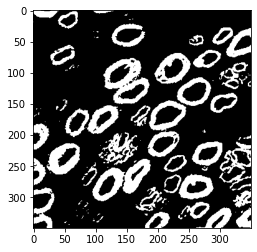

In [84]:
# Binarise and invert image image
I = im[:,:,0]/255
I = (I > 0.35) * 1# binarize image  
I = ~I
plt.imshow(I)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


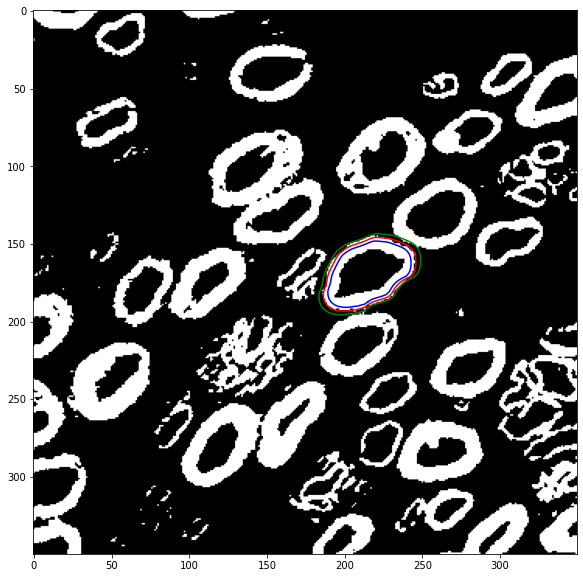

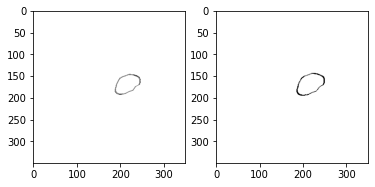

In [111]:
#path = 'data/plusplus.png'
#plusplus = io.imread(path)
#I = plusplus[:,:,0]


# Initialize
nr_points = 60
nr_iter = 50
step_size = 5
alpha = 0.1
beta = 1

center = np.array(I.shape)/2
center = np.array(I.shape)/2+np.array([-10,40])
radius = 0.08*np.mean(I.shape)

snake1 = make_circular_snake(nr_points, center, radius)
B = regularization_matrix(nr_points, alpha, beta)

for i in range(nr_iter): 
    snake = snake1
    snake1,snake_in,snake_out,mask_in,mask_out,force = evolve_snake(snake.copy(), I, B, step_size,band_size=0.1)

# visualize snakes
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.imshow(I, cmap=plt.cm.gray)
ax.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'r-')
ax.plot(np.r_[snake_in[1],snake_in[1,0]],np.r_[snake_in[0],snake_in[0,0]],'b-')
ax.plot(np.r_[snake_out[1],snake_out[1,0]],np.r_[snake_out[0],snake_out[0,0]],'g-')
plt.show()


# visualize mask in and out
img1 = I.copy()
img2 = I.copy()
img1[~mask_in]  = 0.5
img2[~mask_out] = 0.5
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1)
ax[1].imshow(img2)



# plt.imshow(I, cmap=plt.cm.gray)
# plt.plot(np.r_[snake[1],snake[1,0]],np.r_[snake[0],snake[0,0]],'r-')
# plt.plot(np.r_[snake_in[1],snake_in[1,0]],np.r_[snake_in[0],snake_in[0,0]],'b-')
# plt.plot(np.r_[snake_out[1],snake_out[1,0]],np.r_[snake_out[0],snake_out[0,0]],'g-')





# Sunniva

Applying the chan-vese algorithm using scikit-image

In [25]:
# Library import
import matplotlib.pyplot as plt # plotting
import numpy as np # calculations
from skimage import io # image tool
from PIL import Image # image tool
from skimage import data, img_as_float # image tool
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter # for snake
from skimage.segmentation import chan_vese # chan-vese algorithm
from scipy.ndimage import distance_transform_edt as distance # for helper functions

In [65]:
# Helper functions 
def plot_cv(img, cv, rotn=3, figsize=(10,7)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    ax = axes.flatten()

    ax[0].imshow(np.rot90(img,rotn), cmap="gray")
    ax[0].set_axis_off()
    ax[0].set_title("Original Image", fontsize=12)

    ax[1].imshow(np.rot90(cv[0],rotn), cmap="gray")
    ax[1].set_axis_off()
    title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
    ax[1].set_title(title, fontsize=12)

    ax[2].imshow(np.rot90(cv[1],rotn), cmap="gray")
    ax[2].set_axis_off()
    ax[2].set_title("Final Level Set", fontsize=12)

    ax[3].plot(np.array(cv[2])/1000)
    ax[3].set_title("Evolution of energy over iterations", fontsize=12)

    fig.tight_layout()

def snake(image_size, center, radius):
    centerX, centerY = center
    res = np.ones(image_size)
    res[centerY, centerX] = 0.
    return (radius-distance(res)) / (radius*3)

In [37]:
path = 'data/nerves_part.tiff'
im = io.imread(path, plugin='pil').T
h,r,c = im.shape
h, r, c

(350, 350, 1024)

(-0.5, 349.5, 349.5, -0.5)

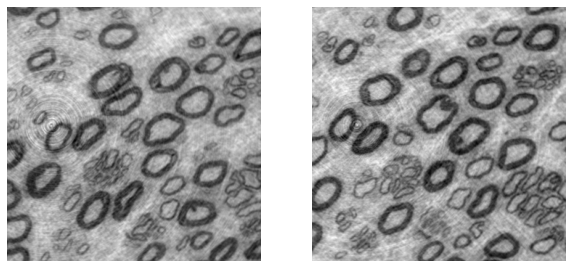

In [39]:
# visualise
fig, ax = plt.subplots(1,2, figsize=(10,7))
plt.gray()
ax[0].imshow(im[:,:,0])
ax[1].imshow(im[:,:,-1])
ax[0].axis('off')
ax[1].axis('off')

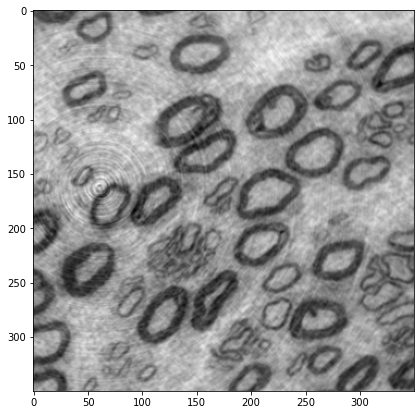

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
plt.gray()
Im = im[:,:,0]
ax.imshow(Im)

In [81]:
init = snake(Im.shape, (175, 175), 40)
cv = chan_vese(Im, mu=0.03, lambda1=1, lambda2=1, tol=1e-3, max_num_iter=5000, 
                dt=0.5, init_level_set=init, extended_output=True)

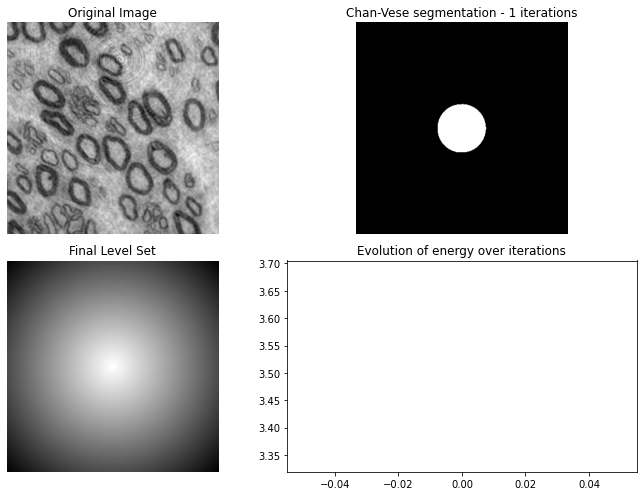

In [77]:
plot_cv(Im, cv)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8e4ab9c-1c0a-457e-84a9-315a391bff2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>